


# Vision Transformer (ViT)
### Alumna: Qualindi Noelia
#### Año 2024 - Cohorte 14

El Vision Transformer (ViT), propuesto por Dosovitskiy et al. (2020), utiliza una arquitectura basada en Transformers para tareas de visión por computadora. A diferencia de las CNN, el ViT aplica **Multi-Head Self-Attention (MHSA)** para modelar relaciones globales entre partes de la imagen.

## Arquitectura

El ViT divide las imágenes en **patches** y las convierte en una secuencia de vectores de características (embeddings), que luego se procesan mediante capas Transformer. A continuación, se aplica el mecanismo de self-attention para modelar las relaciones entre estos patches.

- **Embeddings**: Cada parche se aplana y se proyecta en un espacio de mayor dimensión.
- **Positional Encoding**: Se agrega un embebido posicional para cada parche, permitiendo que el modelo capture las posiciones espaciales.
---
## ¿Cómo funciona el Self-Attention en ViT?

Cada uno de los parches se considera un token similar a las palabras en el procesamiento del lenguaje natural (NLP).
En el mecanismo de Self-Attention, cada uno de estos tokens (parches) puede interactuar con los demás tokens. Para hacerlo, el modelo calcula tres vectores para cada token: 

- **Query:** Representa qué está buscando el token.

- **Key:** Representa una descripción de los demás tokens.

- **Value:** Es la información que tiene cada token y que podría ser relevante para otros tokens.

Luego, se calculan las similitudes entre el *Query* de un token y el *Key* de todos los demás tokens, lo que genera una "puntuación de atención". Esta puntuación determina cuánta atención debe prestar un token a otros. El valor *Value* de cada token se pondera según esta puntuación, lo que permite que un token integre información de todo el resto de la imagen.

Este mecanismo es lo que permite que cada token (parche) en una imagen entienda no solo lo que está ocurriendo en su área local, sino también pueda considerar qué está sucediendo en otras partes de la imagen. 

La fórmula utilizada para calcular la atención es:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Donde:
- **$Q$ (queries)**, **$K$ (keys)**, y **$V$ (values)** son las proyecciones lineales de los embeddings de los patches.
- **$d_k$** es la dimensionalidad de las proyecciones, usada para escalar el producto punto y estabilizar el entrenamiento.

Este proceso se aplica en múltiples cabezas, lo que permite al modelo aprender distintas representaciones.

El mecanismo de self-attention utiliza las proyecciones:

$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$

Donde $X$ es el input y $W_Q$, $W_K$, y $W_V$ son matrices de pesos aprendidos.

Después de aplicar el mecanismo de Self-Attention, los tokens se actualizan, ya que ahora tienen información de los demás tokens. Este proceso se repite varias veces en distintas capas de atención, profundizando la interacción entre los parches.

Salida Final: Después de aplicar múltiples capas de Self-Attention, el modelo agrupa los tokens procesados para predecir la clase de la imagen o realizar otras tareas de visión.


![Vision Transformer](vit_gif.gif)

*Crédito: [lucidrains](https://github.com/lucidrains/vit-pytorch)*


## Tareas:

1. **Implementar la arquitectura de un Vision Transformer** 

2. **Ingresar y ajustar los parametros del modelo***

3. **Probar diferentes técnicas de data augmentation** 

In [10]:
# !pip install scikit-learn==1.5.2

  Using cached scikit_learn-1.5.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-macosx_12_0_arm64.whl (11.0 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.0
    Uninstalling scikit-learn-1.5.0:
      Successfully uninstalled scikit-learn-1.5.0


In [212]:
from tqdm import tqdm
import numpy as np
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from trainer import Trainer

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print('Dispositivo: ',device)
print('Torch version: ',torch.__version__)

Dispositivo:  mps
Torch version:  2.2.0.post100


In [93]:
# La configuración, carga y preprocesamiento
class ConfigPreprocess:
    def __init__(self, device: str, img_path: str, img_size: int, patch_size: int):
        self.device = device
        self.img_path = img_path
        self.img_size = img_size
        self.patch_size = patch_size
        self.test_img = self.load_image()

    def load_image(self):
        return TF.to_tensor(Image.open(self.img_path).resize((self.img_size, self.img_size))).unsqueeze(0).to(self.device)

    def extract_patches(self, image: Tensor) -> Tensor:
        patches = image.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(image.shape[0], -1, self.patch_size, self.patch_size)
        return patches
    

class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches, embed_dim):
        super(PositionalEncodingLearned, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        return x + self.pos_embedding

In [23]:
# Parámetros
img_path = "raccoon.jpg"
img_size = 900
patch_size = 64
embed_dim = 8
patch_idx = 0  # El índice del parche para el cual queres visualiizar la codificación posicional

# Preprocesamiento
config = ConfigPreprocess(device,img_path, img_size, patch_size)

# Extracción de parches y visualización
patches = config.extract_patches(config.test_img.squeeze(0))

# Generación de embeddings
embedded_patches = PatchEmbedding(img_size, patch_size, 3, embed_dim).to(config.device)
patches = embedded_patches(config.test_img)

# Codificación posicional

num_patches = (img_size // patch_size) ** 2
try:
    positional_encoding = PositionalEncodingLearned(num_patches, embed_dim).to(config.device)
    pos_embeddings = positional_encoding(patches)

except Exception as e:
    print(f"Revise la existencia de la función PositionalEncodingLearned. Se produjo error durante la compilación: \n {e}.")


# Transformer Encoder

In [24]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)

# Vision Transformer
Model
> 
```ViT-Base ViT-Large ViT-Huge
    Layers Hidden size D 12 768
    24 1024 32 1280
    MLP size Heads
    Params
    3072 12 86M 4096 16 307M 5120 16 632M
```


In [183]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, num_classes, embed_dim, num_heads, ff_dim, num_layers, dropout):
        super(VisionTransformer, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)  # Para imágenes cuadradas
        
        # Capa de patch embedding
        self.patch_embedding = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)
        
        # inic. de pos_embedding con el tamaño correcto
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, embed_dim)) # se ajusta al numero de parches
        
        # capa del Transformer
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout
        )
        self.transformer_layers = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        
        # Capa de clasificación
        self.fc = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        #print(f"Input shape: {x.shape}") 
        
        # capa de embedding
        x = self.patch_embedding(x)  # Shape: [batch_size, embed_dim, num_patches, num_patches]
        
        # se redimensiona para que sea compatible con el modelo Transformer
        x = x.flatten(2).transpose(1, 2)  # Shape: [batch_size, num_patches, embed_dim]
        
        #print(f"After patch embedding shape: {x.shape}")
        
        # Sumar el pos_embedding
        x = x + self.pos_embedding  # Ahora debería coincidir el tamaño de los tensores
        
        #print(f"After adding pos_embedding shape: {x.shape}")
        
        # capas de Transformer
        x = self.transformer_layers(x)
        
        # primer token para la clasificación
        x = x[:, 0]
        
        # Clasificación
        x = self.fc(x)
        return x


# CIFAR10

In [4]:

# Define transformations for the input data
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784]),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

100%|██████████| 170498071/170498071 [08:15<00:00, 344071.55it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
batch_size = 512 #original

In [113]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [28]:
def get_folder_size(folder_path :os.PathLike) -> str:
    total_size = 0
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            if not os.path.islink(file_path):
                total_size += os.path.getsize(file_path)

    if total_size == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(total_size, 1024)))
    p = math.pow(1024, i)
    s = round(total_size / p, 2)
    return f"{s} {size_name[i]}"


folder_path = './data'
size_in_bytes = get_folder_size(folder_path)
print(f"Tamaño de carpeta: {size_in_bytes}")

Tamaño de carpeta: 340.19 MB


# Modelo

In [114]:
'''
Parámetros del modelo

'''

num_epochs = 10
img_size = 224  
patch_size = 32  # Tamaño de parche razonable para img_size reducido
embed_dim = 32
num_heads = 2
ff_dim = 64
num_layers = 4
num_classes = 10
dropout = 0.1

# Inicializa el modelo
model = VisionTransformer(
    img_size=img_size, 
    patch_size=patch_size, 
    num_classes=num_classes, 
    embed_dim=embed_dim, 
    num_heads=num_heads, 
    ff_dim=ff_dim, 
    num_layers=num_layers, 
    dropout=dropout
).to(device)


print("Parametros del modelo:", list(model.parameters()))

# Definimos funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

model = model.to(device)

try:
    model = torch.compile(model)
except Exception as e:
    print("Se produjo error durante la compilación:", e)

/opt/anaconda3/envs/anaconda_python_3_11/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Parametros del modelo: [Parameter containing:
tensor([[[ 0.1253, -0.9531,  0.8763,  ..., -0.2667, -0.8534, -0.2254],
         [ 0.3769,  0.9383, -0.6187,  ...,  0.6517, -1.5488,  0.0236],
         [ 0.6100,  1.8860,  1.1434,  ..., -0.0172, -0.3160,  0.7455],
         ...,
         [-0.6163,  0.8316,  0.1501,  ..., -1.1981,  0.1617, -1.1552],
         [ 0.1291, -0.9211, -1.0002,  ...,  1.3439, -0.6244,  0.4138],
         [ 0.0333, -0.3689,  0.6652,  ..., -0.3620, -1.0711,  0.9535]]],
       device='mps:0', requires_grad=True), Parameter containing:
tensor([[[[-8.6968e-03, -1.2294e-02, -1.3524e-02,  ...,  1.1594e-02,
           -1.1964e-02, -2.8904e-03],
          [ 1.6770e-02, -1.2499e-02,  3.7328e-04,  ...,  1.5082e-02,
           -1.5775e-02, -9.1742e-03],
          [-2.1499e-04,  5.3991e-03, -1.4973e-02,  ...,  9.0713e-03,
            5.5406e-03,  9.7892e-03],
          ...,
          [ 1.5095e-02, -5.1751e-03,  1.4752e-02,  ...,  1.1794e-03,
           -6.9522e-03, -1.5262e-02],
   

In [273]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of trainable parameters.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000

torch.mps.empty_cache()
print("Número de parámetros: {:.2f} millones".format(count_parameters(model)))

Número de parámetros: 0.33 millones


In [82]:
trainer = Trainer(model, train_loader, test_loader, criterion, optimizer, device)

for epoch in range(num_epochs):
    print(f"Época {epoch+1}/{num_epochs}")
    trainer.train_model(use_amp=True)
    scheduler.step()

Época 1/10


  0%|          | 0/98 [00:00<?, ?it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.95618:   2%|▏         | 2/98 [00:00<00:25,  3.73it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.90504:   4%|▍         | 4/98 [00:00<00:20,  4.61it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.90658:   6%|▌         | 6/98 [00:01<00:18,  4.94it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.90877:   8%|▊         | 8/98 [00:01<00:17,  5.05it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.95010:  10%|█         | 10/98 [00:02<00:17,  5.09it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.85753:  12%|█▏        | 12/98 [00:02<00:17,  4.96it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.96014:  14%|█▍        | 14/98 [00:02<00:16,  5.08it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.92470:  16%|█▋        | 16/98 [00:03<00:15,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.86127:  18%|█▊        | 18/98 [00:03<00:15,  5.19it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.88311:  20%|██        | 20/98 [00:04<00:15,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.87850:  22%|██▏       | 22/98 [00:04<00:14,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.83635:  24%|██▍       | 24/98 [00:04<00:14,  5.15it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.79245:  27%|██▋       | 26/98 [00:05<00:14,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.81320:  29%|██▊       | 28/98 [00:05<00:13,  5.18it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.83464:  31%|███       | 30/98 [00:05<00:13,  5.19it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.84036:  33%|███▎      | 32/98 [00:06<00:12,  5.13it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.84142:  35%|███▍      | 34/98 [00:06<00:12,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.79724:  37%|███▋      | 36/98 [00:07<00:12,  5.16it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.78861:  39%|███▉      | 38/98 [00:07<00:11,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.85844:  41%|████      | 40/98 [00:07<00:11,  5.22it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.82969:  43%|████▎     | 42/98 [00:08<00:11,  5.04it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.88739:  45%|████▍     | 44/98 [00:08<00:10,  5.07it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.77585:  47%|████▋     | 46/98 [00:09<00:10,  5.11it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.80768:  49%|████▉     | 48/98 [00:09<00:09,  5.15it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.78221:  51%|█████     | 50/98 [00:09<00:09,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.76113:  53%|█████▎    | 52/98 [00:10<00:08,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.88690:  55%|█████▌    | 54/98 [00:10<00:08,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.82951:  57%|█████▋    | 56/98 [00:11<00:08,  5.04it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.83802:  58%|█████▊    | 57/98 [00:11<00:08,  4.85it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.82991:  59%|█████▉    | 58/98 [00:11<00:08,  4.71it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.80969:  60%|██████    | 59/98 [00:11<00:08,  4.60it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.79413:  61%|██████    | 60/98 [00:11<00:08,  4.70it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])


loss 1.78147:  62%|██████▏   | 61/98 [00:12<00:07,  4.80it/s]

After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.77245:  64%|██████▍   | 63/98 [00:12<00:07,  4.95it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.84682:  66%|██████▋   | 65/98 [00:12<00:06,  4.85it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.74248:  68%|██████▊   | 67/98 [00:13<00:06,  4.96it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.76245:  70%|███████   | 69/98 [00:13<00:05,  5.03it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.85204:  72%|███████▏  | 71/98 [00:14<00:05,  5.10it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.77392:  74%|███████▍  | 73/98 [00:14<00:04,  5.09it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.78809:  77%|███████▋  | 75/98 [00:14<00:04,  5.09it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.72782:  79%|███████▊  | 77/98 [00:15<00:04,  5.07it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.77477:  81%|████████  | 79/98 [00:15<00:03,  4.82it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.76896:  83%|████████▎ | 81/98 [00:17<00:08,  1.91it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.79827:  84%|████████▎ | 82/98 [00:17<00:06,  2.33it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.72933:  85%|████████▍ | 83/98 [00:18<00:05,  2.63it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.75865:  86%|████████▌ | 84/98 [00:18<00:04,  2.99it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.71261:  87%|████████▋ | 85/98 [00:18<00:03,  3.40it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.70584:  89%|████████▉ | 87/98 [00:18<00:02,  4.06it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.75312:  91%|█████████ | 89/98 [00:19<00:01,  4.50it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.79736:  93%|█████████▎| 91/98 [00:19<00:01,  4.77it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.74267:  95%|█████████▍| 93/98 [00:20<00:01,  4.75it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.76273:  97%|█████████▋| 95/98 [00:20<00:00,  4.93it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.79169:  99%|█████████▉| 97/98 [00:20<00:00,  5.00it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([336, 3, 32, 32])
After patch embedding shape: torch.Size([336, 1, 32])
After adding pos_embedding shape: torch.Size([336, 49, 32])


loss 1.74410: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]


Época 2/10


  0%|          | 0/98 [00:00<?, ?it/s]/opt/anaconda3/envs/anaconda_python_3_11/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.73644:   1%|          | 1/98 [00:00<00:19,  4.99it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.78730:   2%|▏         | 2/98 [00:00<00:19,  4.97it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.73589:   3%|▎         | 3/98 [00:00<00:18,  5.03it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.72879:   4%|▍         | 4/98 [00:00<00:18,  5.04it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.70839:   5%|▌         | 5/98 [00:00<00:18,  5.06it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.76259:   6%|▌         | 6/98 [00:01<00:18,  5.09it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.80522:   7%|▋         | 7/98 [00:01<00:17,  5.10it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.75597:   9%|▉         | 9/98 [00:01<00:17,  4.99it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.81025:  11%|█         | 11/98 [00:02<00:17,  5.08it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.74752:  13%|█▎        | 13/98 [00:02<00:16,  5.13it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.80917:  15%|█▌        | 15/98 [00:02<00:16,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.74292:  17%|█▋        | 17/98 [00:03<00:15,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.71705:  19%|█▉        | 19/98 [00:03<00:15,  5.00it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.74932:  21%|██▏       | 21/98 [00:04<00:15,  5.07it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.72373:  23%|██▎       | 23/98 [00:04<00:14,  5.10it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.72419:  26%|██▌       | 25/98 [00:04<00:14,  5.11it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.69030:  28%|██▊       | 27/98 [00:05<00:13,  5.11it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.69276:  30%|██▉       | 29/98 [00:05<00:13,  4.97it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.72263:  32%|███▏      | 31/98 [00:06<00:13,  5.06it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67208:  34%|███▎      | 33/98 [00:06<00:12,  5.08it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.73280:  36%|███▌      | 35/98 [00:06<00:12,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.73347:  38%|███▊      | 37/98 [00:07<00:11,  5.11it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.70588:  40%|███▉      | 39/98 [00:07<00:11,  4.97it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.69645:  42%|████▏     | 41/98 [00:08<00:11,  5.06it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.69059:  44%|████▍     | 43/98 [00:08<00:10,  5.10it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68212:  46%|████▌     | 45/98 [00:08<00:10,  5.13it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.76331:  48%|████▊     | 47/98 [00:09<00:09,  5.15it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.71786:  50%|█████     | 49/98 [00:09<00:09,  4.97it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67783:  52%|█████▏    | 51/98 [00:10<00:09,  5.05it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67483:  54%|█████▍    | 53/98 [00:10<00:08,  5.08it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.71521:  56%|█████▌    | 55/98 [00:10<00:08,  5.07it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66674:  58%|█████▊    | 57/98 [00:11<00:08,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.73358:  60%|██████    | 59/98 [00:11<00:07,  4.97it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68293:  62%|██████▏   | 61/98 [00:12<00:07,  4.97it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.72610:  64%|██████▍   | 63/98 [00:12<00:06,  5.05it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.71586:  66%|██████▋   | 65/98 [00:12<00:06,  5.11it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.72771:  68%|██████▊   | 67/98 [00:13<00:06,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.78142:  70%|███████   | 69/98 [00:13<00:05,  5.08it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66292:  72%|███████▏  | 71/98 [00:13<00:05,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66419:  74%|███████▍  | 73/98 [00:14<00:04,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64639:  77%|███████▋  | 75/98 [00:14<00:04,  5.16it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63048:  79%|███████▊  | 77/98 [00:15<00:04,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.74918:  80%|███████▉  | 78/98 [00:15<00:04,  4.99it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.69802:  82%|████████▏ | 80/98 [00:15<00:03,  5.07it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67206:  84%|████████▎ | 82/98 [00:16<00:03,  5.13it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.69336:  86%|████████▌ | 84/98 [00:16<00:02,  5.16it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.70240:  88%|████████▊ | 86/98 [00:16<00:02,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.71144:  90%|████████▉ | 88/98 [00:17<00:01,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66258:  92%|█████████▏| 90/98 [00:17<00:01,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.70902:  94%|█████████▍| 92/98 [00:18<00:01,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.71479:  96%|█████████▌| 94/98 [00:18<00:00,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67169:  98%|█████████▊| 96/98 [00:18<00:00,  5.11it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68906:  99%|█████████▉| 97/98 [00:19<00:00,  4.84it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([336, 3, 32, 32])
After patch embedding shape: torch.Size([336, 1, 32])
After adding pos_embedding shape: torch.Size([336, 49, 32])


loss 1.69367: 100%|██████████| 98/98 [00:19<00:00,  5.11it/s]


Época 3/10


  0%|          | 0/98 [00:00<?, ?it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62691:   1%|          | 1/98 [00:00<00:19,  4.99it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68708:   2%|▏         | 2/98 [00:00<00:18,  5.10it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65251:   3%|▎         | 3/98 [00:00<00:18,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65359:   5%|▌         | 5/98 [00:00<00:18,  5.09it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65088:   7%|▋         | 7/98 [00:01<00:17,  5.11it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64881:   9%|▉         | 9/98 [00:01<00:17,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63460:  11%|█         | 11/98 [00:02<00:16,  5.15it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57538:  13%|█▎        | 13/98 [00:02<00:16,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.70375:  14%|█▍        | 14/98 [00:02<00:16,  4.99it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65983:  16%|█▋        | 16/98 [00:03<00:16,  5.06it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.69512:  18%|█▊        | 18/98 [00:03<00:15,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68740:  20%|██        | 20/98 [00:03<00:15,  5.15it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65185:  22%|██▏       | 22/98 [00:04<00:15,  4.98it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64789:  23%|██▎       | 23/98 [00:04<00:15,  4.88it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.70281:  26%|██▌       | 25/98 [00:04<00:14,  5.02it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63336:  28%|██▊       | 27/98 [00:05<00:13,  5.07it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58312:  30%|██▉       | 29/98 [00:05<00:13,  5.13it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66629:  32%|███▏      | 31/98 [00:06<00:13,  4.97it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65453:  34%|███▎      | 33/98 [00:06<00:12,  5.07it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.77565:  36%|███▌      | 35/98 [00:06<00:12,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68422:  38%|███▊      | 37/98 [00:07<00:11,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65403:  40%|███▉      | 39/98 [00:07<00:11,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64119:  42%|████▏     | 41/98 [00:08<00:11,  5.13it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60711:  44%|████▍     | 43/98 [00:08<00:10,  5.16it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64124:  46%|████▌     | 45/98 [00:08<00:10,  5.13it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66141:  48%|████▊     | 47/98 [00:09<00:09,  5.19it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65623:  50%|█████     | 49/98 [00:09<00:09,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66383:  51%|█████     | 50/98 [00:09<00:09,  5.04it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66413:  53%|█████▎    | 52/98 [00:10<00:08,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64116:  55%|█████▌    | 54/98 [00:10<00:08,  5.19it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63294:  57%|█████▋    | 56/98 [00:10<00:08,  5.22it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63551:  59%|█████▉    | 58/98 [00:11<00:07,  5.06it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64744:  61%|██████    | 60/98 [00:11<00:07,  5.15it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59243:  63%|██████▎   | 62/98 [00:12<00:06,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65967:  65%|██████▌   | 64/98 [00:12<00:06,  5.24it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68551:  67%|██████▋   | 66/98 [00:12<00:06,  5.26it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66132:  69%|██████▉   | 68/98 [00:13<00:05,  5.24it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62867:  71%|███████▏  | 70/98 [00:13<00:05,  5.25it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64551:  73%|███████▎  | 72/98 [00:14<00:04,  5.25it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64254:  76%|███████▌  | 74/98 [00:14<00:04,  5.21it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58707:  78%|███████▊  | 76/98 [00:14<00:04,  5.02it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67709:  80%|███████▉  | 78/98 [00:15<00:03,  5.10it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64316:  82%|████████▏ | 80/98 [00:15<00:03,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64443:  84%|████████▎ | 82/98 [00:15<00:03,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68091:  86%|████████▌ | 84/98 [00:16<00:02,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65728:  88%|████████▊ | 86/98 [00:16<00:02,  5.15it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67915:  90%|████████▉ | 88/98 [00:17<00:01,  5.15it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60266:  92%|█████████▏| 90/98 [00:17<00:01,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63504:  94%|█████████▍| 92/98 [00:17<00:01,  5.19it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.70098:  96%|█████████▌| 94/98 [00:18<00:00,  5.02it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67122:  98%|█████████▊| 96/98 [00:18<00:00,  5.11it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67493: 100%|██████████| 98/98 [00:19<00:00,  5.15it/s]


Input shape: torch.Size([336, 3, 32, 32])
After patch embedding shape: torch.Size([336, 1, 32])
After adding pos_embedding shape: torch.Size([336, 49, 32])
Época 4/10


  0%|          | 0/98 [00:00<?, ?it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67947:   1%|          | 1/98 [00:00<00:19,  5.06it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59849:   3%|▎         | 3/98 [00:00<00:19,  4.88it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66918:   5%|▌         | 5/98 [00:00<00:18,  5.06it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63366:   7%|▋         | 7/98 [00:01<00:17,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63828:   9%|▉         | 9/98 [00:01<00:17,  5.02it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68612:  10%|█         | 10/98 [00:01<00:17,  5.04it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60409:  12%|█▏        | 12/98 [00:02<00:17,  4.93it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61265:  14%|█▍        | 14/98 [00:02<00:16,  5.06it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68069:  16%|█▋        | 16/98 [00:03<00:16,  5.10it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63606:  18%|█▊        | 18/98 [00:03<00:15,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68055:  20%|██        | 20/98 [00:03<00:15,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62692:  22%|██▏       | 22/98 [00:04<00:14,  5.15it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.71222:  24%|██▍       | 24/98 [00:04<00:14,  5.11it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66122:  27%|██▋       | 26/98 [00:05<00:13,  5.16it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59653:  29%|██▊       | 28/98 [00:05<00:13,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66031:  31%|███       | 30/98 [00:05<00:13,  5.05it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58232:  33%|███▎      | 32/98 [00:06<00:12,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67424:  35%|███▍      | 34/98 [00:06<00:12,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62598:  37%|███▋      | 36/98 [00:07<00:11,  5.22it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65878:  39%|███▉      | 38/98 [00:07<00:11,  5.23it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64789:  41%|████      | 40/98 [00:07<00:11,  5.07it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57888:  43%|████▎     | 42/98 [00:08<00:10,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63775:  45%|████▍     | 44/98 [00:08<00:10,  5.21it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68596:  47%|████▋     | 46/98 [00:08<00:09,  5.23it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65738:  49%|████▉     | 48/98 [00:09<00:09,  5.07it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.71821:  51%|█████     | 50/98 [00:09<00:09,  5.15it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63730:  53%|█████▎    | 52/98 [00:10<00:08,  5.21it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67605:  55%|█████▌    | 54/98 [00:10<00:08,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66203:  57%|█████▋    | 56/98 [00:10<00:08,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64793:  59%|█████▉    | 58/98 [00:11<00:07,  5.19it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65351:  61%|██████    | 60/98 [00:11<00:07,  5.21it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64242:  63%|██████▎   | 62/98 [00:12<00:06,  5.23it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58739:  65%|██████▌   | 64/98 [00:12<00:06,  5.22it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64337:  67%|██████▋   | 66/98 [00:12<00:06,  5.06it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67671:  69%|██████▉   | 68/98 [00:13<00:05,  5.11it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67233:  71%|███████▏  | 70/98 [00:13<00:05,  5.18it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65256:  73%|███████▎  | 72/98 [00:13<00:04,  5.21it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63245:  76%|███████▌  | 74/98 [00:14<00:04,  5.22it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58113:  78%|███████▊  | 76/98 [00:14<00:04,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62271:  80%|███████▉  | 78/98 [00:15<00:03,  5.23it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59503:  82%|████████▏ | 80/98 [00:15<00:03,  5.21it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62221:  84%|████████▎ | 82/98 [00:15<00:03,  5.11it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62236:  86%|████████▌ | 84/98 [00:16<00:02,  4.96it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.53818:  88%|████████▊ | 86/98 [00:16<00:02,  5.06it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67984:  90%|████████▉ | 88/98 [00:17<00:01,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63568:  92%|█████████▏| 90/98 [00:17<00:01,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66912:  94%|█████████▍| 92/98 [00:17<00:01,  5.24it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67425:  95%|█████████▍| 93/98 [00:18<00:00,  5.05it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66080:  97%|█████████▋| 95/98 [00:18<00:00,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63253:  99%|█████████▉| 97/98 [00:18<00:00,  5.19it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([336, 3, 32, 32])
After patch embedding shape: torch.Size([336, 1, 32])
After adding pos_embedding shape: torch.Size([336, 49, 32])


loss 1.65667: 100%|██████████| 98/98 [00:18<00:00,  5.17it/s]


Época 5/10


  0%|          | 0/98 [00:00<?, ?it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59710:   1%|          | 1/98 [00:00<00:21,  4.57it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.69221:   2%|▏         | 2/98 [00:00<00:19,  4.93it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63416:   3%|▎         | 3/98 [00:00<00:18,  5.04it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63814:   4%|▍         | 4/98 [00:00<00:18,  5.10it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57655:   5%|▌         | 5/98 [00:00<00:18,  5.09it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60536:   6%|▌         | 6/98 [00:01<00:17,  5.15it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64358:   7%|▋         | 7/98 [00:01<00:17,  5.13it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63611:   8%|▊         | 8/98 [00:01<00:17,  5.16it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65014:   9%|▉         | 9/98 [00:01<00:17,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60116:  10%|█         | 10/98 [00:01<00:16,  5.19it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59480:  11%|█         | 11/98 [00:02<00:16,  5.21it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64332:  12%|█▏        | 12/98 [00:02<00:16,  5.21it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64679:  14%|█▍        | 14/98 [00:02<00:16,  4.96it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61721:  16%|█▋        | 16/98 [00:03<00:16,  5.11it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60546:  18%|█▊        | 18/98 [00:03<00:15,  5.19it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.69013:  20%|██        | 20/98 [00:03<00:14,  5.23it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61250:  22%|██▏       | 22/98 [00:04<00:14,  5.21it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60401:  23%|██▎       | 23/98 [00:04<00:14,  5.04it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.69014:  26%|██▌       | 25/98 [00:04<00:14,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.73681:  28%|██▊       | 27/98 [00:05<00:13,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66138:  30%|██▉       | 29/98 [00:05<00:13,  5.22it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62903:  32%|███▏      | 31/98 [00:06<00:12,  5.24it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62548:  34%|███▎      | 33/98 [00:06<00:12,  5.19it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63361:  36%|███▌      | 35/98 [00:06<00:12,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65551:  38%|███▊      | 37/98 [00:07<00:11,  5.23it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63942:  40%|███▉      | 39/98 [00:07<00:11,  5.25it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67288:  42%|████▏     | 41/98 [00:07<00:10,  5.25it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63230:  44%|████▍     | 43/98 [00:08<00:10,  5.23it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60545:  46%|████▌     | 45/98 [00:08<00:10,  5.24it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63529:  48%|████▊     | 47/98 [00:09<00:09,  5.25it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66592:  50%|█████     | 49/98 [00:09<00:09,  5.25it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63297:  52%|█████▏    | 51/98 [00:09<00:08,  5.26it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66268:  54%|█████▍    | 53/98 [00:10<00:08,  5.23it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60187:  56%|█████▌    | 55/98 [00:10<00:08,  5.25it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60104:  58%|█████▊    | 57/98 [00:10<00:07,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64599:  60%|██████    | 59/98 [00:11<00:07,  5.28it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63391:  62%|██████▏   | 61/98 [00:11<00:07,  5.27it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67060:  63%|██████▎   | 62/98 [00:11<00:07,  5.11it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68074:  65%|██████▌   | 64/98 [00:12<00:06,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65949:  67%|██████▋   | 66/98 [00:12<00:06,  5.25it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62660:  69%|██████▉   | 68/98 [00:13<00:05,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63508:  71%|███████▏  | 70/98 [00:13<00:05,  5.30it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.56156:  73%|███████▎  | 72/98 [00:13<00:05,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62038:  76%|███████▌  | 74/98 [00:14<00:04,  5.23it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64920:  78%|███████▊  | 76/98 [00:14<00:04,  5.28it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.55909:  80%|███████▉  | 78/98 [00:14<00:03,  5.27it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61836:  82%|████████▏ | 80/98 [00:15<00:03,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64935:  84%|████████▎ | 82/98 [00:15<00:03,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62303:  86%|████████▌ | 84/98 [00:16<00:02,  5.22it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62400:  88%|████████▊ | 86/98 [00:16<00:02,  5.27it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57951:  90%|████████▉ | 88/98 [00:16<00:01,  5.21it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67235:  91%|█████████ | 89/98 [00:17<00:01,  5.10it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66639:  92%|█████████▏| 90/98 [00:17<00:01,  5.06it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57524:  93%|█████████▎| 91/98 [00:17<00:01,  4.64it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66844:  94%|█████████▍| 92/98 [00:17<00:01,  4.67it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64629:  96%|█████████▌| 94/98 [00:18<00:00,  4.98it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.70564:  98%|█████████▊| 96/98 [00:18<00:00,  5.15it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66985: 100%|██████████| 98/98 [00:18<00:00,  5.20it/s]


Input shape: torch.Size([336, 3, 32, 32])
After patch embedding shape: torch.Size([336, 1, 32])
After adding pos_embedding shape: torch.Size([336, 49, 32])
Época 6/10


  0%|          | 0/98 [00:00<?, ?it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63199:   1%|          | 1/98 [00:00<00:18,  5.13it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57844:   2%|▏         | 2/98 [00:00<00:18,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.70663:   3%|▎         | 3/98 [00:00<00:18,  5.21it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60039:   4%|▍         | 4/98 [00:00<00:18,  5.22it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63264:   5%|▌         | 5/98 [00:00<00:17,  5.19it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61752:   7%|▋         | 7/98 [00:01<00:18,  4.90it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60439:   8%|▊         | 8/98 [00:01<00:19,  4.66it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62304:   9%|▉         | 9/98 [00:01<00:18,  4.82it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63038:  11%|█         | 11/98 [00:02<00:17,  5.02it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59515:  13%|█▎        | 13/98 [00:02<00:16,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60281:  15%|█▌        | 15/98 [00:02<00:16,  4.95it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68494:  16%|█▋        | 16/98 [00:03<00:16,  4.86it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61526:  17%|█▋        | 17/98 [00:03<00:16,  4.83it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64003:  19%|█▉        | 19/98 [00:03<00:15,  5.06it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64951:  21%|██▏       | 21/98 [00:04<00:14,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65076:  23%|██▎       | 23/98 [00:04<00:14,  5.24it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.55464:  26%|██▌       | 25/98 [00:04<00:13,  5.28it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67357:  27%|██▋       | 26/98 [00:05<00:14,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63900:  29%|██▊       | 28/98 [00:05<00:13,  5.22it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63816:  31%|███       | 30/98 [00:05<00:12,  5.27it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63714:  33%|███▎      | 32/98 [00:06<00:12,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63025:  35%|███▍      | 34/98 [00:06<00:12,  5.31it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65863:  36%|███▌      | 35/98 [00:06<00:12,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62846:  38%|███▊      | 37/98 [00:07<00:11,  5.23it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57610:  40%|███▉      | 39/98 [00:07<00:11,  5.26it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67433:  42%|████▏     | 41/98 [00:07<00:10,  5.27it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60958:  44%|████▍     | 43/98 [00:08<00:10,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58894:  46%|████▌     | 45/98 [00:08<00:10,  4.96it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57983:  47%|████▋     | 46/98 [00:09<00:10,  4.75it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61740:  48%|████▊     | 47/98 [00:09<00:10,  4.87it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67470:  50%|█████     | 49/98 [00:09<00:09,  5.09it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66137:  52%|█████▏    | 51/98 [00:09<00:09,  5.19it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59324:  54%|█████▍    | 53/98 [00:10<00:09,  4.88it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.56638:  56%|█████▌    | 55/98 [00:10<00:08,  5.10it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61230:  58%|█████▊    | 57/98 [00:11<00:07,  5.18it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62703:  60%|██████    | 59/98 [00:11<00:07,  5.26it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66466:  62%|██████▏   | 61/98 [00:11<00:06,  5.30it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62573:  64%|██████▍   | 63/98 [00:12<00:06,  5.09it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67310:  66%|██████▋   | 65/98 [00:12<00:06,  5.15it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.69111:  68%|██████▊   | 67/98 [00:13<00:06,  5.15it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59277:  70%|███████   | 69/98 [00:13<00:05,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59754:  72%|███████▏  | 71/98 [00:13<00:05,  5.21it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66057:  74%|███████▍  | 73/98 [00:14<00:04,  5.13it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60966:  77%|███████▋  | 75/98 [00:14<00:04,  5.22it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65290:  79%|███████▊  | 77/98 [00:14<00:03,  5.27it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65991:  81%|████████  | 79/98 [00:15<00:03,  5.30it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61356:  83%|████████▎ | 81/98 [00:15<00:03,  5.30it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66364:  85%|████████▍ | 83/98 [00:16<00:02,  5.27it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.55962:  87%|████████▋ | 85/98 [00:16<00:02,  5.27it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59025:  89%|████████▉ | 87/98 [00:16<00:02,  5.31it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58321:  91%|█████████ | 89/98 [00:17<00:01,  5.30it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63981:  93%|█████████▎| 91/98 [00:17<00:01,  5.30it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61384:  95%|█████████▍| 93/98 [00:18<00:00,  5.27it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65621:  97%|█████████▋| 95/98 [00:18<00:00,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65581:  99%|█████████▉| 97/98 [00:18<00:00,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([336, 3, 32, 32])
After patch embedding shape: torch.Size([336, 1, 32])
After adding pos_embedding shape: torch.Size([336, 49, 32])


loss 1.53319: 100%|██████████| 98/98 [00:18<00:00,  5.19it/s]


Época 7/10


loss 1.60956:   1%|          | 1/98 [00:00<00:18,  5.27it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59496:   2%|▏         | 2/98 [00:00<00:19,  4.96it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.53973:   4%|▍         | 4/98 [00:00<00:18,  5.16it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64348:   6%|▌         | 6/98 [00:01<00:17,  5.25it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.70013:   8%|▊         | 8/98 [00:01<00:16,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64334:  10%|█         | 10/98 [00:01<00:16,  5.32it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62992:  12%|█▏        | 12/98 [00:02<00:16,  5.27it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65988:  14%|█▍        | 14/98 [00:02<00:15,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66170:  16%|█▋        | 16/98 [00:03<00:15,  5.31it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63873:  18%|█▊        | 18/98 [00:03<00:15,  5.30it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58005:  20%|██        | 20/98 [00:03<00:14,  5.31it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57894:  22%|██▏       | 22/98 [00:04<00:14,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61382:  24%|██▍       | 24/98 [00:04<00:14,  5.13it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65726:  26%|██▌       | 25/98 [00:04<00:14,  5.04it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58705:  28%|██▊       | 27/98 [00:05<00:13,  5.18it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63855:  29%|██▊       | 28/98 [00:05<00:13,  5.02it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67394:  31%|███       | 30/98 [00:05<00:13,  4.98it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57430:  33%|███▎      | 32/98 [00:06<00:12,  5.16it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61011:  35%|███▍      | 34/98 [00:06<00:12,  5.25it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60703:  37%|███▋      | 36/98 [00:06<00:11,  5.25it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67482:  39%|███▉      | 38/98 [00:07<00:11,  5.28it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63183:  41%|████      | 40/98 [00:07<00:10,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61134:  43%|████▎     | 42/98 [00:08<00:10,  5.33it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.69709:  45%|████▍     | 44/98 [00:08<00:10,  5.34it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58351:  47%|████▋     | 46/98 [00:08<00:09,  5.31it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62177:  49%|████▉     | 48/98 [00:09<00:09,  5.31it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57530:  51%|█████     | 50/98 [00:09<00:09,  5.30it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66492:  53%|█████▎    | 52/98 [00:09<00:08,  5.32it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61108:  54%|█████▍    | 53/98 [00:10<00:08,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66865:  55%|█████▌    | 54/98 [00:10<00:09,  4.82it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67608:  56%|█████▌    | 55/98 [00:10<00:09,  4.75it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64816:  57%|█████▋    | 56/98 [00:10<00:08,  4.75it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65892:  59%|█████▉    | 58/98 [00:11<00:07,  5.04it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.56301:  61%|██████    | 60/98 [00:11<00:07,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66433:  63%|██████▎   | 62/98 [00:11<00:07,  4.99it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60488:  64%|██████▍   | 63/98 [00:12<00:06,  5.09it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60986:  66%|██████▋   | 65/98 [00:12<00:06,  5.18it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63442:  68%|██████▊   | 67/98 [00:12<00:05,  5.25it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59712:  70%|███████   | 69/98 [00:13<00:05,  5.28it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65063:  72%|███████▏  | 71/98 [00:13<00:05,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62617:  74%|███████▍  | 73/98 [00:14<00:04,  5.24it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58733:  77%|███████▋  | 75/98 [00:14<00:04,  5.28it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59010:  79%|███████▊  | 77/98 [00:14<00:03,  5.31it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62445:  81%|████████  | 79/98 [00:15<00:03,  5.33it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61351:  83%|████████▎ | 81/98 [00:15<00:03,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57908:  85%|████████▍ | 83/98 [00:15<00:02,  5.24it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59763:  87%|████████▋ | 85/98 [00:16<00:02,  5.30it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59957:  89%|████████▉ | 87/98 [00:16<00:02,  5.32it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65351:  91%|█████████ | 89/98 [00:17<00:01,  5.33it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.69095:  93%|█████████▎| 91/98 [00:17<00:01,  5.27it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62547:  95%|█████████▍| 93/98 [00:17<00:00,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65253:  97%|█████████▋| 95/98 [00:18<00:00,  5.32it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63926:  99%|█████████▉| 97/98 [00:18<00:00,  5.32it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([336, 3, 32, 32])
After patch embedding shape: torch.Size([336, 1, 32])
After adding pos_embedding shape: torch.Size([336, 49, 32])


loss 1.66007: 100%|██████████| 98/98 [00:18<00:00,  5.24it/s]


Época 8/10


loss 1.67337:   1%|          | 1/98 [00:00<00:18,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63186:   2%|▏         | 2/98 [00:00<00:18,  5.25it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.69991:   3%|▎         | 3/98 [00:00<00:17,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58707:   4%|▍         | 4/98 [00:00<00:17,  5.30it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57927:   5%|▌         | 5/98 [00:00<00:17,  5.30it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63730:   6%|▌         | 6/98 [00:01<00:17,  5.31it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.55212:   7%|▋         | 7/98 [00:01<00:17,  5.27it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62774:   8%|▊         | 8/98 [00:01<00:16,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62263:   9%|▉         | 9/98 [00:01<00:16,  5.28it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68930:  10%|█         | 10/98 [00:01<00:16,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65426:  11%|█         | 11/98 [00:02<00:16,  5.30it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58295:  12%|█▏        | 12/98 [00:02<00:16,  5.31it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63339:  13%|█▎        | 13/98 [00:02<00:16,  5.27it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61256:  14%|█▍        | 14/98 [00:02<00:15,  5.28it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61989:  15%|█▌        | 15/98 [00:02<00:15,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57639:  16%|█▋        | 16/98 [00:03<00:15,  5.30it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66118:  17%|█▋        | 17/98 [00:03<00:15,  5.31it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.69657:  19%|█▉        | 19/98 [00:03<00:15,  5.13it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64329:  21%|██▏       | 21/98 [00:03<00:14,  5.24it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60091:  23%|██▎       | 23/98 [00:04<00:14,  5.27it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58830:  26%|██▌       | 25/98 [00:04<00:13,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62553:  28%|██▊       | 27/98 [00:05<00:13,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61541:  30%|██▉       | 29/98 [00:05<00:13,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64187:  32%|███▏      | 31/98 [00:05<00:12,  5.19it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60130:  34%|███▎      | 33/98 [00:06<00:12,  5.21it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65360:  36%|███▌      | 35/98 [00:06<00:12,  5.23it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64662:  38%|███▊      | 37/98 [00:07<00:12,  5.07it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60650:  40%|███▉      | 39/98 [00:07<00:11,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68195:  42%|████▏     | 41/98 [00:07<00:10,  5.22it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63084:  44%|████▍     | 43/98 [00:08<00:10,  5.25it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59280:  46%|████▌     | 45/98 [00:08<00:10,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66779:  47%|████▋     | 46/98 [00:08<00:10,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67205:  49%|████▉     | 48/98 [00:09<00:09,  5.24it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64719:  51%|█████     | 50/98 [00:09<00:09,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65609:  53%|█████▎    | 52/98 [00:09<00:08,  5.23it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59958:  55%|█████▌    | 54/98 [00:10<00:08,  5.06it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64559:  57%|█████▋    | 56/98 [00:10<00:08,  5.16it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60790:  59%|█████▉    | 58/98 [00:11<00:07,  5.21it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59886:  61%|██████    | 60/98 [00:11<00:07,  5.26it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65937:  63%|██████▎   | 62/98 [00:11<00:06,  5.24it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67678:  65%|██████▌   | 64/98 [00:12<00:06,  5.24it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62497:  67%|██████▋   | 66/98 [00:12<00:06,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65917:  69%|██████▉   | 68/98 [00:12<00:05,  5.26it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.56833:  71%|███████▏  | 70/98 [00:13<00:05,  5.28it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59333:  73%|███████▎  | 72/98 [00:13<00:05,  5.05it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57265:  76%|███████▌  | 74/98 [00:14<00:04,  5.15it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68071:  78%|███████▊  | 76/98 [00:14<00:04,  5.21it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62172:  80%|███████▉  | 78/98 [00:14<00:03,  5.23it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67473:  82%|████████▏ | 80/98 [00:15<00:03,  5.26it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63336:  83%|████████▎ | 81/98 [00:15<00:03,  5.04it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66270:  85%|████████▍ | 83/98 [00:15<00:02,  5.15it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.55825:  87%|████████▋ | 85/98 [00:16<00:02,  5.23it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63759:  89%|████████▉ | 87/98 [00:16<00:02,  5.10it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59336:  90%|████████▉ | 88/98 [00:16<00:02,  4.87it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68830:  91%|█████████ | 89/98 [00:17<00:01,  4.70it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58537:  92%|█████████▏| 90/98 [00:17<00:01,  4.75it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63056:  94%|█████████▍| 92/98 [00:17<00:01,  5.03it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64112:  96%|█████████▌| 94/98 [00:18<00:00,  5.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.55231:  98%|█████████▊| 96/98 [00:18<00:00,  4.97it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66939: 100%|██████████| 98/98 [00:18<00:00,  5.21it/s]


Input shape: torch.Size([336, 3, 32, 32])
After patch embedding shape: torch.Size([336, 1, 32])
After adding pos_embedding shape: torch.Size([336, 49, 32])
Época 9/10


  0%|          | 0/98 [00:00<?, ?it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62307:   1%|          | 1/98 [00:00<00:18,  5.22it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.53618:   2%|▏         | 2/98 [00:00<00:18,  5.22it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64170:   3%|▎         | 3/98 [00:00<00:18,  5.23it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66061:   4%|▍         | 4/98 [00:00<00:18,  5.19it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61547:   5%|▌         | 5/98 [00:00<00:17,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64384:   6%|▌         | 6/98 [00:01<00:17,  5.21it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62395:   7%|▋         | 7/98 [00:01<00:17,  5.22it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61778:   8%|▊         | 8/98 [00:01<00:17,  5.24it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67501:  10%|█         | 10/98 [00:01<00:17,  5.09it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65295:  12%|█▏        | 12/98 [00:02<00:16,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59172:  14%|█▍        | 14/98 [00:02<00:16,  5.23it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65796:  16%|█▋        | 16/98 [00:03<00:15,  5.26it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60029:  18%|█▊        | 18/98 [00:03<00:15,  5.27it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64957:  19%|█▉        | 19/98 [00:03<00:15,  4.98it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58478:  20%|██        | 20/98 [00:03<00:15,  4.89it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58834:  21%|██▏       | 21/98 [00:04<00:15,  4.82it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62534:  23%|██▎       | 23/98 [00:04<00:14,  5.06it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57418:  26%|██▌       | 25/98 [00:04<00:14,  5.19it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59637:  27%|██▋       | 26/98 [00:05<00:14,  5.05it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60524:  28%|██▊       | 27/98 [00:05<00:14,  4.97it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66470:  30%|██▉       | 29/98 [00:05<00:13,  5.09it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61260:  32%|███▏      | 31/98 [00:06<00:12,  5.21it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.69909:  34%|███▎      | 33/98 [00:06<00:12,  5.11it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62359:  36%|███▌      | 35/98 [00:06<00:12,  5.21it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67509:  38%|███▊      | 37/98 [00:07<00:11,  5.28it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67914:  40%|███▉      | 39/98 [00:07<00:11,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.55768:  42%|████▏     | 41/98 [00:07<00:11,  5.13it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.56870:  43%|████▎     | 42/98 [00:08<00:10,  5.13it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66524:  45%|████▍     | 44/98 [00:08<00:10,  5.20it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.56510:  47%|████▋     | 46/98 [00:08<00:09,  5.25it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58717:  49%|████▉     | 48/98 [00:09<00:09,  5.29it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64248:  51%|█████     | 50/98 [00:09<00:09,  5.13it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64746:  53%|█████▎    | 52/98 [00:10<00:08,  5.22it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.69064:  55%|█████▌    | 54/98 [00:10<00:08,  5.30it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.54970:  57%|█████▋    | 56/98 [00:10<00:08,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67999:  58%|█████▊    | 57/98 [00:11<00:08,  5.11it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58746:  59%|█████▉    | 58/98 [00:11<00:08,  4.67it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66712:  60%|██████    | 59/98 [00:11<00:08,  4.66it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.72634:  61%|██████    | 60/98 [00:11<00:08,  4.58it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60347:  62%|██████▏   | 61/98 [00:11<00:07,  4.67it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66544:  63%|██████▎   | 62/98 [00:12<00:07,  4.74it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63571:  64%|██████▍   | 63/98 [00:12<00:07,  4.77it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61389:  65%|██████▌   | 64/98 [00:12<00:07,  4.80it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62647:  66%|██████▋   | 65/98 [00:12<00:06,  4.84it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61448:  67%|██████▋   | 66/98 [00:12<00:07,  4.51it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65494:  68%|██████▊   | 67/98 [00:13<00:06,  4.60it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60774:  69%|██████▉   | 68/98 [00:13<00:06,  4.64it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67479:  70%|███████   | 69/98 [00:13<00:06,  4.68it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67732:  71%|███████▏  | 70/98 [00:13<00:05,  4.74it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68939:  72%|███████▏  | 71/98 [00:14<00:05,  4.78it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62862:  73%|███████▎  | 72/98 [00:14<00:05,  4.81it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58056:  74%|███████▍  | 73/98 [00:14<00:05,  4.82it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62869:  76%|███████▌  | 74/98 [00:14<00:04,  4.83it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66781:  77%|███████▋  | 75/98 [00:14<00:04,  4.82it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60300:  78%|███████▊  | 76/98 [00:15<00:04,  4.84it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57376:  79%|███████▊  | 77/98 [00:15<00:04,  4.87it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62495:  80%|███████▉  | 78/98 [00:15<00:04,  4.85it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60378:  81%|████████  | 79/98 [00:15<00:03,  4.86it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.70806:  82%|████████▏ | 80/98 [00:15<00:03,  4.86it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58740:  83%|████████▎ | 81/98 [00:16<00:03,  4.85it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60447:  84%|████████▎ | 82/98 [00:16<00:03,  4.87it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68690:  85%|████████▍ | 83/98 [00:16<00:03,  4.86it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62189:  86%|████████▌ | 84/98 [00:16<00:02,  4.90it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62325:  88%|████████▊ | 86/98 [00:17<00:02,  5.01it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.53277:  90%|████████▉ | 88/98 [00:17<00:01,  5.04it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58217:  92%|█████████▏| 90/98 [00:17<00:01,  5.04it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.56640:  94%|█████████▍| 92/98 [00:18<00:01,  5.10it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59461:  96%|█████████▌| 94/98 [00:18<00:00,  4.95it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65082:  97%|█████████▋| 95/98 [00:18<00:00,  4.60it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61273:  98%|█████████▊| 96/98 [00:19<00:00,  4.66it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60080:  99%|█████████▉| 97/98 [00:19<00:00,  4.67it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65482: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]


Input shape: torch.Size([336, 3, 32, 32])
After patch embedding shape: torch.Size([336, 1, 32])
After adding pos_embedding shape: torch.Size([336, 49, 32])
Época 10/10


  0%|          | 0/98 [00:00<?, ?it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63571:   2%|▏         | 2/98 [00:00<00:20,  4.69it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61983:   3%|▎         | 3/98 [00:00<00:19,  4.87it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67521:   5%|▌         | 5/98 [00:01<00:18,  4.95it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67123:   7%|▋         | 7/98 [00:01<00:18,  4.80it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68038:   9%|▉         | 9/98 [00:02<00:30,  2.95it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65911:  11%|█         | 11/98 [00:02<00:23,  3.70it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66443:  13%|█▎        | 13/98 [00:03<00:20,  4.12it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62852:  14%|█▍        | 14/98 [00:03<00:19,  4.24it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61886:  15%|█▌        | 15/98 [00:03<00:18,  4.46it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59644:  17%|█▋        | 17/98 [00:03<00:17,  4.57it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61012:  19%|█▉        | 19/98 [00:04<00:16,  4.81it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65418:  21%|██▏       | 21/98 [00:04<00:15,  4.99it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60461:  23%|██▎       | 23/98 [00:05<00:15,  4.98it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64983:  24%|██▍       | 24/98 [00:05<00:14,  4.98it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65371:  26%|██▌       | 25/98 [00:05<00:14,  5.00it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66855:  28%|██▊       | 27/98 [00:05<00:13,  5.08it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.68011:  30%|██▉       | 29/98 [00:06<00:13,  5.10it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57074:  32%|███▏      | 31/98 [00:06<00:13,  4.93it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67971:  34%|███▎      | 33/98 [00:07<00:13,  5.00it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63993:  36%|███▌      | 35/98 [00:07<00:12,  5.04it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62192:  38%|███▊      | 37/98 [00:07<00:11,  5.11it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67205:  40%|███▉      | 39/98 [00:08<00:11,  5.02it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57555:  41%|████      | 40/98 [00:08<00:11,  5.09it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63670:  43%|████▎     | 42/98 [00:08<00:10,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65116:  45%|████▍     | 44/98 [00:09<00:10,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64036:  47%|████▋     | 46/98 [00:09<00:10,  5.15it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65177:  49%|████▉     | 48/98 [00:10<00:09,  5.14it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61239:  51%|█████     | 50/98 [00:10<00:09,  5.17it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61668:  53%|█████▎    | 52/98 [00:10<00:08,  5.19it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67795:  55%|█████▌    | 54/98 [00:11<00:08,  5.18it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65006:  57%|█████▋    | 56/98 [00:11<00:08,  5.13it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59501:  59%|█████▉    | 58/98 [00:11<00:07,  5.09it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.57025:  61%|██████    | 60/98 [00:12<00:07,  5.07it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64267:  63%|██████▎   | 62/98 [00:12<00:07,  5.07it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.71328:  65%|██████▌   | 64/98 [00:13<00:06,  4.93it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63585:  67%|██████▋   | 66/98 [00:13<00:06,  5.04it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59620:  69%|██████▉   | 68/98 [00:13<00:05,  5.09it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65090:  71%|███████▏  | 70/98 [00:14<00:05,  5.01it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62864:  73%|███████▎  | 72/98 [00:14<00:05,  4.66it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.69374:  74%|███████▍  | 73/98 [00:15<00:05,  4.56it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58553:  76%|███████▌  | 74/98 [00:15<00:05,  4.40it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.52301:  77%|███████▋  | 75/98 [00:15<00:05,  4.34it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.55959:  78%|███████▊  | 76/98 [00:15<00:04,  4.47it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66142:  79%|███████▊  | 77/98 [00:15<00:04,  4.59it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59985:  80%|███████▉  | 78/98 [00:16<00:04,  4.69it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.56349:  81%|████████  | 79/98 [00:16<00:04,  4.74it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64738:  82%|████████▏ | 80/98 [00:16<00:03,  4.63it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61621:  83%|████████▎ | 81/98 [00:16<00:03,  4.65it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65865:  84%|████████▎ | 82/98 [00:17<00:03,  4.69it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.58720:  85%|████████▍ | 83/98 [00:17<00:03,  4.74it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67431:  86%|████████▌ | 84/98 [00:17<00:02,  4.76it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63875:  87%|████████▋ | 85/98 [00:17<00:02,  4.78it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.65987:  88%|████████▊ | 86/98 [00:17<00:02,  4.81it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.67262:  89%|████████▉ | 87/98 [00:18<00:02,  4.78it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.61677:  90%|████████▉ | 88/98 [00:18<00:02,  4.80it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.62704:  91%|█████████ | 89/98 [00:18<00:01,  4.83it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.59167:  92%|█████████▏| 90/98 [00:18<00:01,  4.84it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.60424:  93%|█████████▎| 91/98 [00:18<00:01,  4.88it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.63811:  94%|█████████▍| 92/98 [00:19<00:01,  4.83it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66969:  95%|█████████▍| 93/98 [00:19<00:01,  4.89it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.66453:  97%|█████████▋| 95/98 [00:19<00:00,  5.05it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


loss 1.64413:  99%|█████████▉| 97/98 [00:20<00:00,  5.13it/s]

Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])
Input shape: torch.Size([336, 3, 32, 32])
After patch embedding shape: torch.Size([336, 1, 32])
After adding pos_embedding shape: torch.Size([336, 49, 32])


loss 1.60080: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]


In [83]:
def visualize_classification(model, data_loader, class_names, device, num_images=16):
    model.eval()
    images_shown = 0
    fig = plt.figure(figsize=(15, 15))
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for i in range(images.size(0)):
                images_shown += 1
                ax = plt.subplot(num_images // 4, 4, images_shown)
                ax.axis('off')
                ax.set_title(f'True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}')
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                img = img * [0.24703223, 0.24348513, 0.26158784] + [0.49139968, 0.48215841, 0.44653091]
                img = np.clip(img, 0, 1)
                ax.imshow(img)
                if images_shown == num_images:
                    return


Input shape: torch.Size([512, 3, 32, 32])
After patch embedding shape: torch.Size([512, 1, 32])
After adding pos_embedding shape: torch.Size([512, 49, 32])


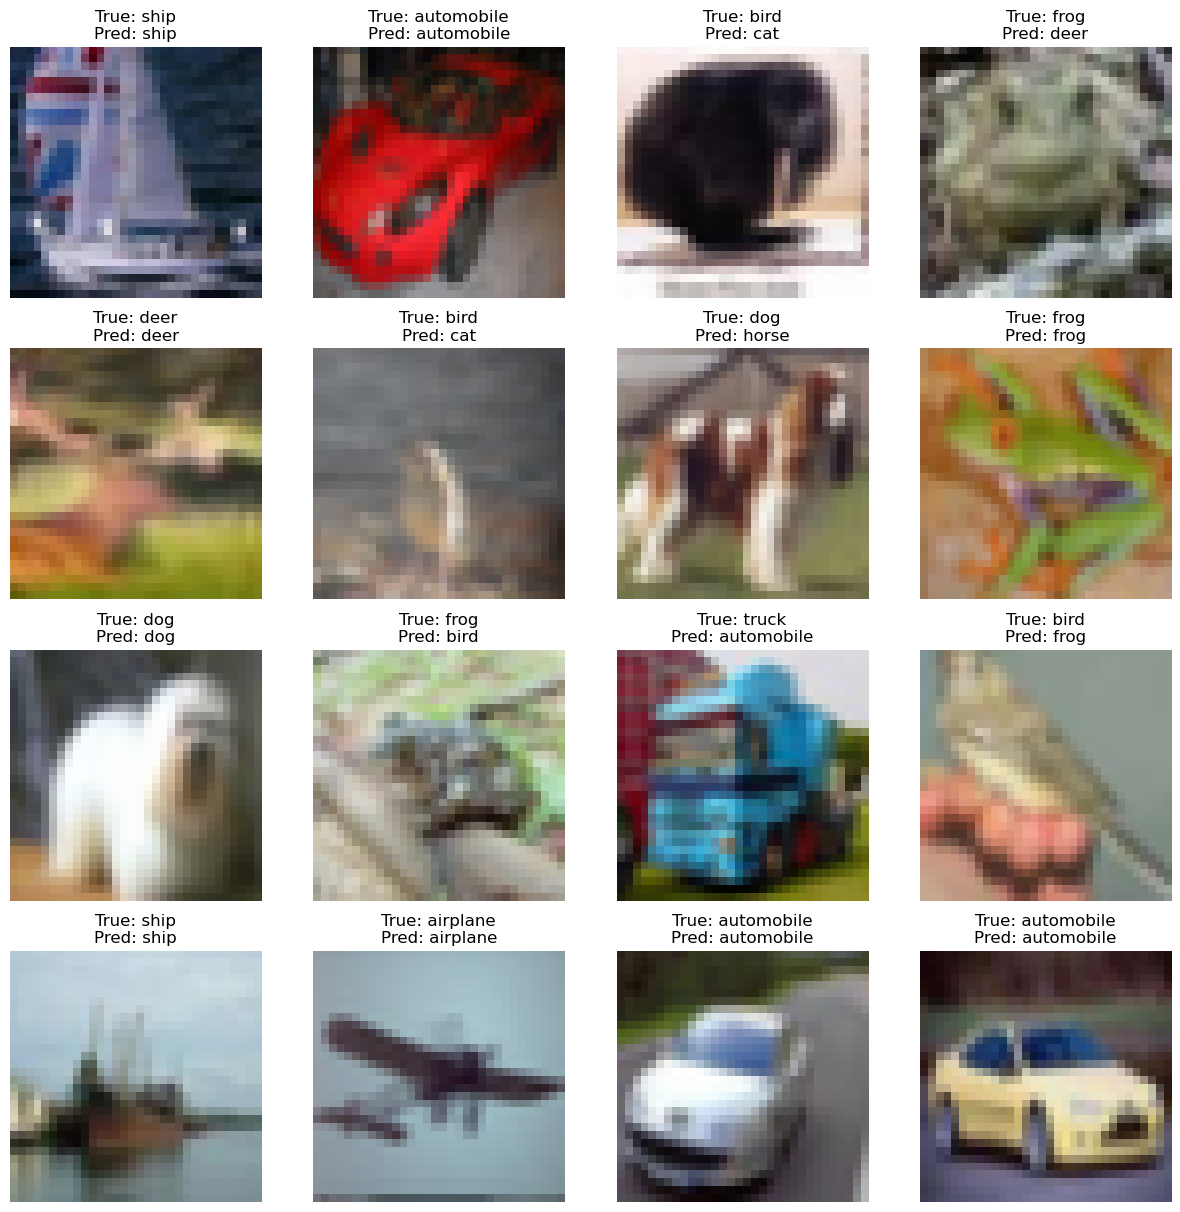

In [84]:
class_names = train_dataset.classes
visualize_classification(model, test_loader, class_names, device)
plt.show()

In [85]:
train_dataset.data[0].shape

(32, 32, 3)

## Cambiando parámetros y aumentando los datos

In [275]:
# Hiperparámetros
num_epochs = 10 
img_size = 32 # de cifar10
patch_size = 32
embed_dim = 64  # Aumenta la dimensión de embedding
num_heads = 2
ff_dim = 128  # Aumenta la dimensión de la capa feed-forward
num_layers = 4
num_classes = 10
dropout = 0.3 
batch_size = 128
learning_rate = 1e-4

In [282]:
def eval_model(model, loss_fn, device):
    """
    Evalúa el modelo en el conjunto de datos de prueba y calcula la pérdida y la precisión.

    :param model: El modelo a evaluar.
    :param loss_fn: Función de pérdida que se utiliza para calcular la pérdida.
    :param device: Dispositivo (CPU/GPU) donde se encuentra el modelo y los datos.

    :return: Tupla (val_loss, accuracy), donde:
        - val_loss: La pérdida promedio en el conjunto de prueba.
        - accuracy: La precisión en el conjunto de prueba.
    """
    model = model.eval()
    losses = []
    correct = 0
    total = 0
    bar = tqdm(test_loader, desc="Evaluando", leave=False)

    with torch.no_grad():
        for val_input, val_mask in bar:
            val_input, val_mask = val_input.to(device), val_mask.to(device)
            outputs = model(val_input)

            # Cálculo de la pérdida
            loss = loss_fn(outputs, val_mask)
            losses.append(loss.item())

            # Cálculo de precisión (accuracy)
            _, predicted = torch.max(outputs, 1)
            total += val_mask.size(0)
            correct += (predicted == val_mask).sum().item()

            bar.set_description(f"Val Loss: {loss:.5f}, Accuracy: {100 * correct / total:.2f}%")

    avg_loss = np.mean(losses)
    accuracy = correct / total * 100
    return avg_loss, accuracy

### Transformaciones

In [283]:
# Transforms (Aumento de datos)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [284]:
# Carga del dataset CIFAR10 a partir de las transformaciones
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [285]:
# Inicializar modelo
model_with_augmentation = VisionTransformer(
    img_size=img_size, 
    patch_size=patch_size, 
    num_classes=num_classes, 
    embed_dim=embed_dim, 
    num_heads=num_heads, 
    ff_dim=ff_dim, 
    num_layers=num_layers, 
    dropout=dropout
).to(device)

In [290]:
# Funciones de pérdida y optimizador, se prueba con otro optimizador (SGD)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_with_augmentation.parameters(), lr=learning_rate, momentum=0.9) 
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

model_2 = model_with_augmentation.to(device)

try:
    model_2 = torch.compile(model_2)
except Exception as e:
    print("Se produjo error durante la compilación:", e)

In [291]:
print("Número de parámetros: {:.2f} millones".format(count_parameters(model_2)))

Número de parámetros: 0.33 millones


### Entrenamiento

In [292]:
trainer_with_augmentation = Trainer(model_2, train_loader, test_loader, criterion, optimizer, device)

for epoch in range(num_epochs):
    print(f"Época {epoch+1}/{num_epochs}")
     # entrenamiento
    train_loss = trainer_with_augmentation.train_model(use_amp=True)

    # evaluación
    val_loss, accuracy = eval_model(model_with_augmentation, criterion, device)
    print(f"Época {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Accuracy: {accuracy}")

Época 1/10


  0%|          | 0/391 [00:00<?, ?it/s]/opt/anaconda3/envs/anaconda_python_3_11/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2024-11-07 18:18:29,959] torch._dynamo.convert_frame: [WARNING] WON'T CONVERT forward /var/folders/ml/g_sxsst10mj890krz6gpp0980000gn/T/ipykernel_52446/3905544069.py line 28 
[2024-11-07 18:18:29,959] torch._dynamo.convert_frame: [WARNING] due to: 
[2024-11-07 18:18:29,959] torch._dynamo.convert_frame: [WARNING] Traceback (most recent call last):
[2024-11-07 18:18:29,959] torch._dynamo.convert_frame: [WARNING]   File "/opt/anaconda3/envs/anaconda_python_3_11/lib/python3.11/site-packages/torch/_dynamo/convert_frame.py", line 727, in _convert_frame
[2024-11-07 18:18:29,959] torch._dynamo.convert_frame: [WARNING]     result = inner_convert(frame, cache_entry, hooks, frame_state)
[2024-11-07 18:18:29,959] torch._dynamo.convert_frame: [WARNING]      

Época 1/10, Train Loss: 1.8890704745831697, Validation Loss: 1.8582708669614187, Accuracy: 35.18
Época 2/10


loss 1.95932: 100%|██████████| 391/391 [00:14<00:00, 27.53it/s]


Época 2/10, Train Loss: 1.8754578786128013, Validation Loss: 1.8493183881421633, Accuracy: 35.199999999999996
Época 3/10


loss 1.92107: 100%|██████████| 391/391 [00:14<00:00, 27.77it/s]


Época 3/10, Train Loss: 1.8638225696275912, Validation Loss: 1.8388218864609924, Accuracy: 35.339999999999996
Época 4/10


loss 1.94514: 100%|██████████| 391/391 [00:14<00:00, 27.55it/s]


Época 4/10, Train Loss: 1.8540151564361493, Validation Loss: 1.82764962202386, Accuracy: 35.93
Época 5/10


loss 1.71498: 100%|██████████| 391/391 [00:13<00:00, 28.00it/s]


Época 5/10, Train Loss: 1.8457339142289613, Validation Loss: 1.8224718736696848, Accuracy: 36.559999999999995
Época 6/10


loss 1.84130: 100%|██████████| 391/391 [00:13<00:00, 28.48it/s]


Época 6/10, Train Loss: 1.8343780071229276, Validation Loss: 1.8135937527765202, Accuracy: 36.57
Época 7/10


loss 1.71915: 100%|██████████| 391/391 [00:13<00:00, 28.54it/s]


Época 7/10, Train Loss: 1.8278612651483481, Validation Loss: 1.802623385115515, Accuracy: 36.47
Época 8/10


loss 1.76735: 100%|██████████| 391/391 [00:13<00:00, 28.00it/s]


Época 8/10, Train Loss: 1.823718505747178, Validation Loss: 1.793364781367628, Accuracy: 37.14
Época 9/10


loss 1.73012: 100%|██████████| 391/391 [00:13<00:00, 28.37it/s]


Época 9/10, Train Loss: 1.8120342227808959, Validation Loss: 1.784661474107187, Accuracy: 37.47
Época 10/10


loss 1.77600: 100%|██████████| 391/391 [00:14<00:00, 27.35it/s]
                                                                                    

Época 10/10, Train Loss: 1.8067510868887158, Validation Loss: 1.778958273839347, Accuracy: 37.269999999999996


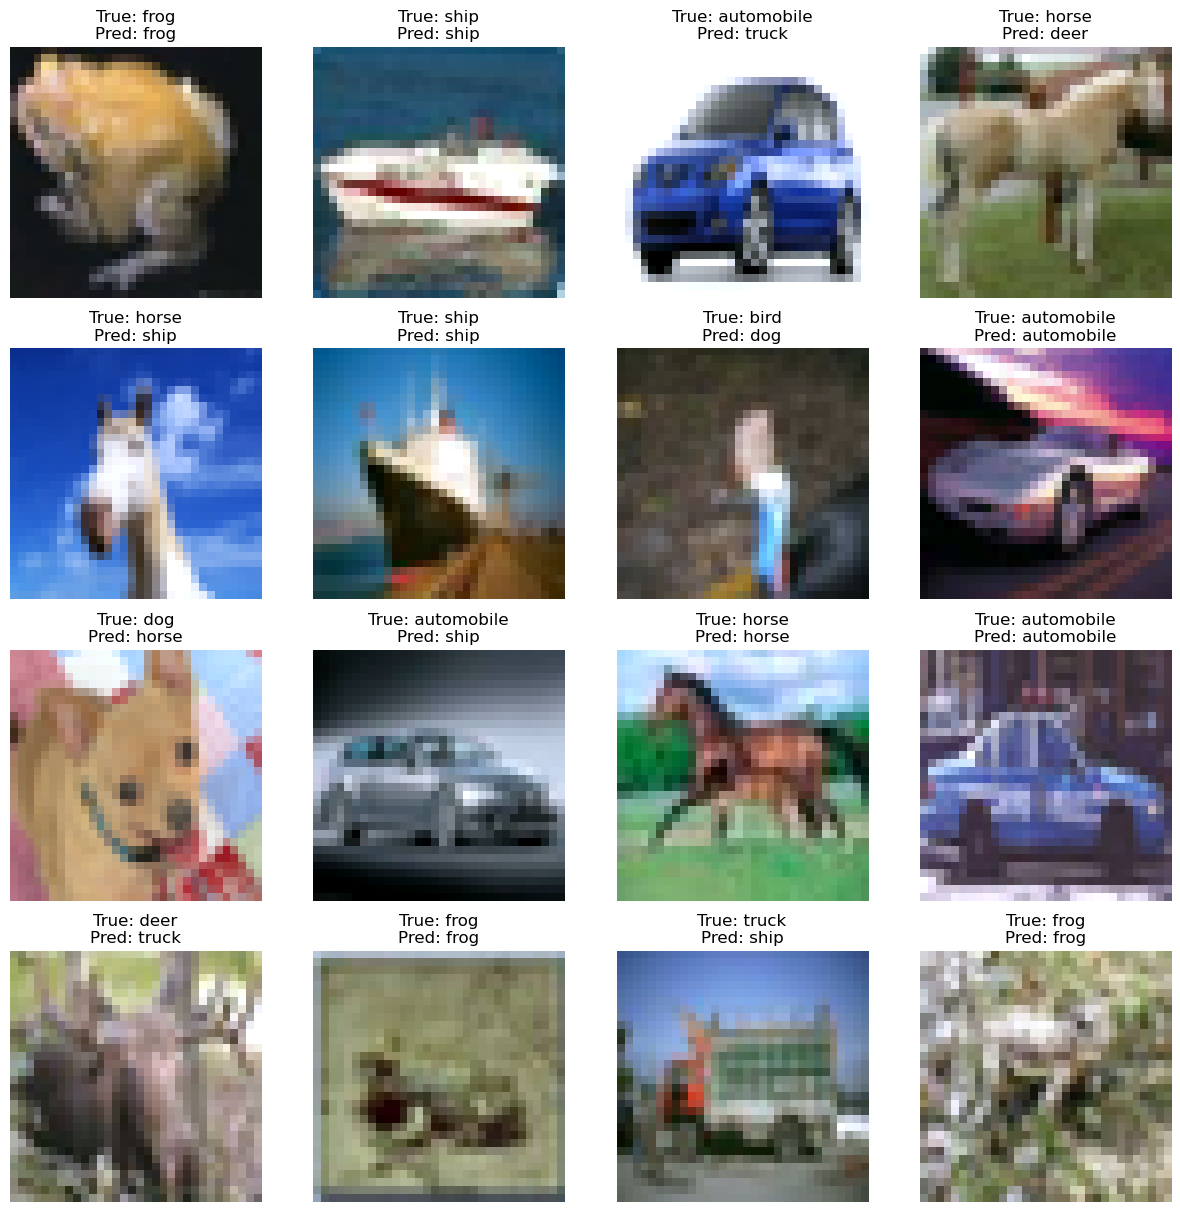

In [293]:
class_names = train_dataset.classes
visualize_classification(model_2, test_loader, class_names, device)
plt.show()

### Prueba con otros hiperparámetros

In [294]:
num_epochs = 20     # se cambia a 20 epocas 
img_size = 256      # mas info espacial a diferencia de la prueba anterior
patch_size = 32     # tamaño del parche (32x32)
embed_dim = 128      # dimensión de los embeddings
num_heads = 8       # número de cabezas de atención
ff_dim = 256        # dimensión de la capa feed-forward
num_layers = 8      # número de capas Transformer
num_classes = 10    # número de clases (CIFAR-10 tiene 10 clases)
dropout = 0.4       # tasa de abandono
batch_size = 128
learning_rate = 1e-4  # se cambia el lr a un valor más alto
early_stopping_patience = 3  # aplicar EarlyStopping si no mejora después de 3 épocas

In [295]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from trainer import EarlyStopping 

model_with_augmentation = VisionTransformer(
    img_size=img_size, 
    patch_size=patch_size, 
    num_classes=num_classes, 
    embed_dim=embed_dim, 
    num_heads=num_heads, 
    ff_dim=ff_dim, 
    num_layers=num_layers, 
    dropout=dropout
).to(device)

# Funciones de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_with_augmentation.parameters(), lr=learning_rate)  
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=early_stopping_patience, verbose=True)  # Reducir LR cuando la validación no mejora

# EarlyStopping
early_stopping = EarlyStopping(patience=early_stopping_patience)

model_3 = model_with_augmentation.to(device)

try:
    model_3 = torch.compile(model_3)
except Exception as e:
    print("Se produjo error durante la compilación:", e)

/opt/anaconda3/envs/anaconda_python_3_11/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/opt/anaconda3/envs/anaconda_python_3_11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [296]:
print("Número de parámetros: {:.2f} millones".format(count_parameters(model_3)))

Número de parámetros: 1.46 millones


In [297]:
from trainer import Trainer
trainer_with_augmentation = Trainer(model_3, train_loader, test_loader, criterion, optimizer, device)

for epoch in range(num_epochs):
    print(f"Época {epoch+1}/{num_epochs}")
    
    # entrenamiento
    train_loss = trainer_with_augmentation.train_model(use_amp=True)

    # evaluación
    val_loss, accuracy = eval_model(model_with_augmentation, criterion, device)
    print(f"Época {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Accuracy: {accuracy}")

    # actualiza el scheduler
    scheduler.step(val_loss)

    if early_stopping(model_with_augmentation, val_loss):
        print("Early stopping")
        break


Época 1/20


  0%|          | 0/391 [00:00<?, ?it/s]/opt/anaconda3/envs/anaconda_python_3_11/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
loss 1.81902: 100%|██████████| 391/391 [00:55<00:00,  7.05it/s]


Época 1/20, Train Loss: 2.005480601964399, Validation Loss: 1.7778428159182584, Accuracy: 36.33
Época 2/20


loss 1.64407: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]


Época 2/20, Train Loss: 1.8217507082483042, Validation Loss: 1.6624384665790992, Accuracy: 39.58
Época 3/20


loss 1.73818: 100%|██████████| 391/391 [00:54<00:00,  7.13it/s]


Época 3/20, Train Loss: 1.7546175084150661, Validation Loss: 1.5954620491100262, Accuracy: 42.21
Época 4/20


loss 1.61999: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]


Época 4/20, Train Loss: 1.7114949781266624, Validation Loss: 1.5794117752509782, Accuracy: 42.559999999999995
Época 5/20


loss 1.45570: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]


Época 5/20, Train Loss: 1.6725155898677113, Validation Loss: 1.5464455975761897, Accuracy: 44.59
Época 6/20


loss 1.42790: 100%|██████████| 391/391 [00:55<00:00,  7.01it/s]


Época 6/20, Train Loss: 1.647789820685716, Validation Loss: 1.5113524877572362, Accuracy: 45.33
Época 7/20


loss 1.44454: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]


Época 7/20, Train Loss: 1.6218302838332819, Validation Loss: 1.491852862925469, Accuracy: 46.0
Época 8/20


loss 1.74918: 100%|██████████| 391/391 [00:54<00:00,  7.13it/s]


Época 8/20, Train Loss: 1.6005871238001168, Validation Loss: 1.4872501198249528, Accuracy: 45.910000000000004
Época 9/20


loss 1.45680: 100%|██████████| 391/391 [00:55<00:00,  7.02it/s]


Época 9/20, Train Loss: 1.582364298498539, Validation Loss: 1.4714809776861457, Accuracy: 47.43
Época 10/20


loss 1.60764: 100%|██████████| 391/391 [00:56<00:00,  6.94it/s]


Época 10/20, Train Loss: 1.5661554110934361, Validation Loss: 1.4438780757445324, Accuracy: 48.33
Época 11/20


loss 1.72191: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]


Época 11/20, Train Loss: 1.551601043747514, Validation Loss: 1.4315996185133728, Accuracy: 48.370000000000005
Época 12/20


loss 1.61775: 100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


Época 12/20, Train Loss: 1.5391783195993174, Validation Loss: 1.4124976426740237, Accuracy: 49.28
Época 13/20


loss 1.58433: 100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


Época 13/20, Train Loss: 1.52765884057945, Validation Loss: 1.4023351276977152, Accuracy: 49.81
Época 14/20


loss 1.74706: 100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


Época 14/20, Train Loss: 1.5167054596459468, Validation Loss: 1.4043484066106096, Accuracy: 49.53
Época 15/20


loss 1.43703: 100%|██████████| 391/391 [00:54<00:00,  7.17it/s]


Época 15/20, Train Loss: 1.5064568854963687, Validation Loss: 1.3793870225737366, Accuracy: 50.1
Época 16/20


loss 1.53325: 100%|██████████| 391/391 [00:55<00:00,  7.02it/s]


Época 16/20, Train Loss: 1.4918264684164921, Validation Loss: 1.3745878859411311, Accuracy: 50.62
Época 17/20


loss 1.56076: 100%|██████████| 391/391 [00:55<00:00,  6.99it/s]


Época 17/20, Train Loss: 1.4869344511910167, Validation Loss: 1.3819759269303913, Accuracy: 50.580000000000005
Época 18/20


loss 1.57812: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]


Época 18/20, Train Loss: 1.481069774274021, Validation Loss: 1.3673609208457078, Accuracy: 51.239999999999995
Época 19/20


loss 1.51609: 100%|██████████| 391/391 [00:54<00:00,  7.18it/s]


Época 19/20, Train Loss: 1.4683924565839646, Validation Loss: 1.3520158755628369, Accuracy: 51.790000000000006
Época 20/20


loss 1.50480: 100%|██████████| 391/391 [00:54<00:00,  7.19it/s]
                                                                                    

Época 20/20, Train Loss: 1.4651611860450882, Validation Loss: 1.3449816552898552, Accuracy: 52.04


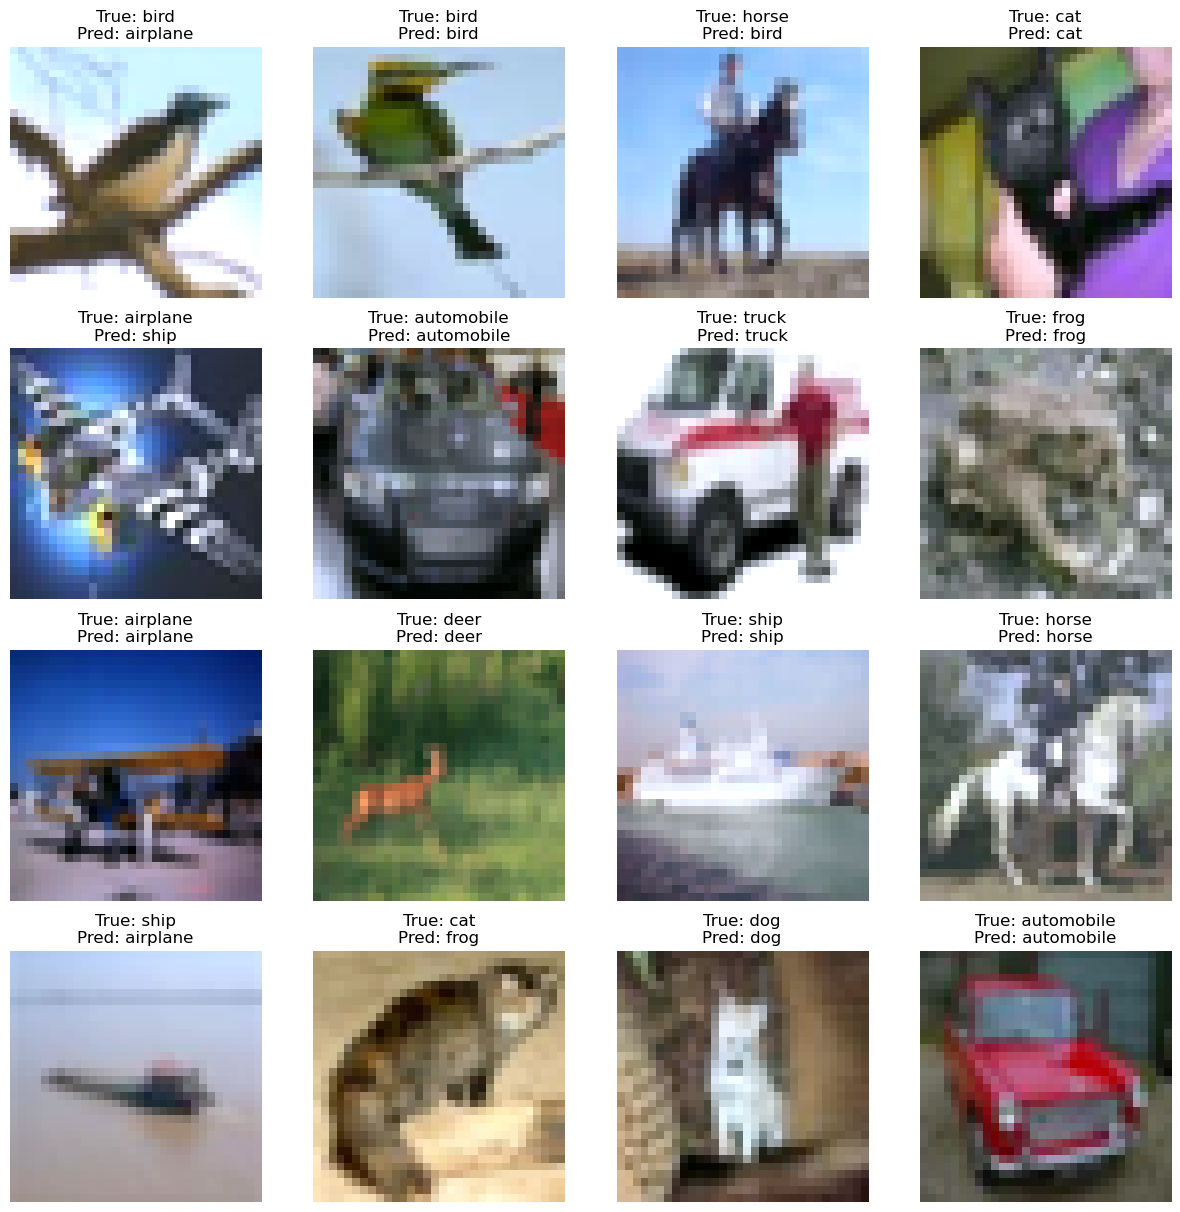

In [298]:
class_names = train_dataset.classes
visualize_classification(model_with_augmentation, test_loader, class_names, device)
plt.show()

## Conclusiones de los Modelos
### Modelo 1 (original):

Configuración: Sin cambios en la arquitectura, usa parámetros iniciales y optimizador Adam.
- Resultados:
Al parecer, el modelo ha tenido problemas para mejorar significativamente sus métricas.
Las métricas como la precisión y la pérdida se han estancado, sugiriendo que el modelo puede estar limitado por la arquitectura y los hiperparámetros iniciales.
Este modelo no parece tener un rendimiento competitivo en CIFAR-10, debido por la arquitectura y parámetros de entrenamiento inadecuados para este conjunto de datos.

### Modelo 2 (con aumentación de datos):

- Configuración: Aumenta embed_dim a 64, ff_dim a 128, y el número de capas a 4. Usa optimizador SGD con tasa de aprendizaje más baja. Batch Size de 128, y dropout de 0.3. Imagen con tamaño CIFAR-10 de 32x32.
- Resultados: La pérdida de entrenamiento y validación ha disminuido gradualmente a lo largo de las épocas, con el último Train Loss de 1.81 y Validation Loss de 1.77.
Precisión final de 37.27%.
Aunque hay mejoras ligeras, la precisión sigue siendo relativamente baja.
El uso de SGD y el ajuste de hiperparámetros lograron reducir la pérdida y aumentar la precisión, aunque el modelo aún no generaliza bien en CIFAR-10. Una posible causa es el tamaño de la imagen y el valor bajo de embed_dim, que podrían no capturar suficientes características.

### Modelo 3 (con aumentación de datos):

- Configuración: img_size incrementado a 256 para captar más detalles. embed_dim aumentado a 128, num_heads a 8, ff_dim a 256 y num_layers a 8. Batch Size de 128, dropout de 0.4. Early Stopping aplicado para evitar el sobreajuste.
- Resultados: Pérdida y precisión mejoran consistentemente, con un último Train Loss de 1.53 y Validation Loss de 1.41 en la época 13.
La precisión alcanza un 49.28% en la última época reportada, lo cual es un avance considerable en comparación con los otros modelos.
El entrenamiento no llegó a 20 épocas completas gracias a Early Stopping, lo que evitó un entrenamiento innecesario.

Este modelo muestra un rendimiento mucho más competitivo en CIFAR-10, con una precisión cercana al 50%. La combinación de un tamaño de imagen más grande, mayor dimensión de embedding, y más capas ha permitido capturar mejor las características del dataset.

## Rendimiento General: 

El Modelo 3 mostró el mejor rendimiento, beneficiándose de una configuración más compleja con un embed_dim y ff_dim mayores, así como más capas de atención y una mayor tasa de dropout.